Loaded 100 subjects with 8 impressions each.
Train subjects: 70, Test subjects: 30
Estimating covariance inverse on training subjects (PKBT + center + l2norm)...
Done. PKBT key kept internal.
Computing scores on test subjects (Mahalanobis + centroid enrollment)...
genuine count = 150, impostor count = 870
mean genuine distance = 52.4191, mean impostor distance = 29.6255
mean genuine distance = 51.5825, mean impostor distance = 29.6827
mean genuine distance = 52.0261, mean impostor distance = 29.5390
mean genuine distance = 52.0996, mean impostor distance = 29.6625
mean genuine distance = 53.4028, mean impostor distance = 29.7050
mean genuine distance = 52.3828, mean impostor distance = 29.6441
mean genuine distance = 52.6384, mean impostor distance = 29.7385
mean genuine distance = 52.1819, mean impostor distance = 29.6942
mean genuine distance = 52.8354, mean impostor distance = 29.7626
mean genuine distance = 51.8204, mean impostor distance = 29.5599
mean genuine distance = 52.6266, 

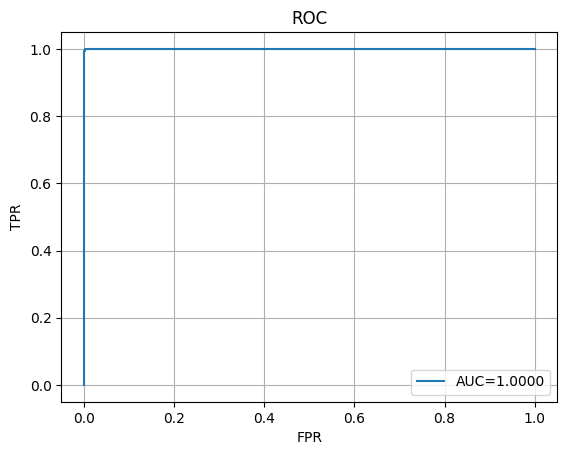

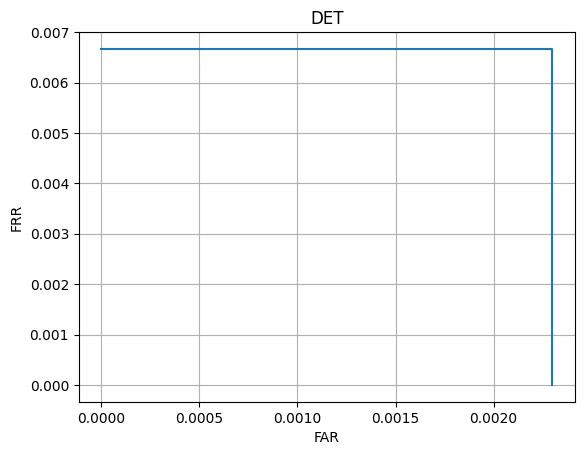

In [ ]:
# verification-1:1-matching
import os
import cv2
import numpy as np
from scipy.signal import hilbert
from sklearn.metrics import roc_curve, auc, det_curve
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten
from sklearn.covariance import LedoitWolf
import random

# -------------------
# Config (changed IMAGE_SIZE -> 224 to match MobileNet pretrained expectation)
# -------------------
IMAGE_SIZE = (224, 224)          # use 224 to match pretrained MobileNet weights
DATASET_PATH = "/kaggle/input/fycalldaatsetsss/74034_3_En_4_MOESM1_ESM/FVC2004/Dbs/DB4_A"
NUM_SUBJECTS = 100
NUM_IMPRESSIONS = 8
ENROLL_IMPRESSIONS = 3
PROBE_IMPRESSIONS = NUM_IMPRESSIONS - ENROLL_IMPRESSIONS
KEY = None
TRAIN_SPLIT = 0.7
RANDOM_SEED = 42
BOOTSTRAP_N = 500                # reduce for speed (increase as needed)

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# -------------------
# Utils / Loader
# -------------------
def load_dataset(dataset_path):
    subjects = {}
    for file in sorted(os.listdir(dataset_path)):
        if file.lower().endswith(".tif"):
            name = file.replace(".tif", "")
            parts = name.split("_")
            if len(parts) < 2:
                continue
            try:
                subj = int(parts[0])
            except:
                continue
            img_path = os.path.join(dataset_path, file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, IMAGE_SIZE)
            subjects.setdefault(subj, []).append(img)
    # keep only full-subjects
    for subj in list(subjects.keys()):
        if len(subjects[subj]) != NUM_IMPRESSIONS:
            print(f"Warning: Subject {subj} has {len(subjects[subj])} impressions → skipping")
            del subjects[subj]
        else:
            subjects[subj] = np.array(subjects[subj])
    return subjects

# -------------------
# Feature extractor
# -------------------
def build_feature_extractor():
    base = MobileNet(weights="imagenet", include_top=False, input_shape=IMAGE_SIZE + (3,))
    for layer in base.layers:
        layer.trainable = False
    model = Sequential([base, GlobalAveragePooling2D(), Flatten()])
    return model

def extract_features(model, images):
    imgs = preprocess_input(images.astype("float32"))
    return model.predict(imgs, verbose=0)

# -------------------
# PKBT transform
# -------------------
def apply_pkbt(features, key=None):
    # features: (N, D)
    if key is None or len(key) != features.shape[1]:
        key = np.random.randint(1, 255, (features.shape[1],), dtype=np.uint8)
    analytic_signal = hilbert(features, axis=1)
    magnitude = np.abs(analytic_signal)
    phase = np.angle(analytic_signal)
    expanded_key = np.tile(key, (features.shape[0], 1))
    mod_phase = (phase + expanded_key / 255.0) % (2 * np.pi)
    transformed = magnitude * np.exp(1j * mod_phase)
    # return real part, plus key
    return np.real(transformed), key

# -------------------
# Normalization helpers
# -------------------
def center_and_l2normalize(X):
    """
    Center features column-wise (zero mean) then l2-normalize each row.
    X shape: (N, D)
    """
    Xc = X - np.mean(X, axis=0, keepdims=True)
    norms = np.linalg.norm(Xc, axis=1, keepdims=True)
    norms = np.where(norms == 0, 1e-10, norms)
    Xn = Xc / norms
    return Xn

# -------------------
# Mahalanobis
# -------------------
def mahalanobis_distance(a, b, cov_inv):
    diff = a - b
    val = np.dot(np.dot(diff.T, cov_inv), diff)
    return np.sqrt(max(val, 0.0))

# -------------------
# Subject split & covariance estimation (on TRAIN only)
# -------------------
def split_subjects(subjects, train_ratio=0.7):
    subj_ids = sorted(list(subjects.keys()))
    np.random.shuffle(subj_ids)
    split_idx = int(len(subj_ids) * train_ratio)
    train_ids = subj_ids[:split_idx]
    test_ids = subj_ids[split_idx:]
    train_subjects = {sid: subjects[sid] for sid in train_ids}
    test_subjects = {sid: subjects[sid] for sid in test_ids}
    return train_subjects, test_subjects

def estimate_cov_inv(train_subjects, extractor, key=None, regularize=1e-6):
    all_feats = []
    for subj, imgs in train_subjects.items():
        feats = extract_features(extractor, imgs)             # (8, D)
        feats, key = apply_pkbt(feats, key)                   # (8, D)
        feats = center_and_l2normalize(feats)                 # normalize
        all_feats.append(feats)
    all_feats = np.vstack(all_feats)                          # (num_train_samples, D)
    lw = LedoitWolf().fit(all_feats)
    cov = lw.covariance_
    cov += regularize * np.eye(cov.shape[0])
    cov_inv = np.linalg.inv(cov)
    return cov_inv, key

# -------------------
# Compute scores on TEST (Mahalanobis + centroid enrollment)
# -------------------
def compute_scores_mahalanobis(test_subjects, extractor, cov_inv, key):
    transformed = {}
    for subj, imgs in test_subjects.items():
        feats = extract_features(extractor, imgs)
        feats, _ = apply_pkbt(feats, key)
        feats = center_and_l2normalize(feats)
        transformed[subj] = feats

    genuine, impostor = [], []
    # precompute templates (centroids)
    templates = {s: np.mean(feats[:ENROLL_IMPRESSIONS], axis=0) for s, feats in transformed.items()}

    # genuine: template vs each probe for same subject
    for subj, feats in transformed.items():
        template = templates[subj]
        probes = feats[ENROLL_IMPRESSIONS:]
        for p in probes:
            genuine.append(mahalanobis_distance(template, p, cov_inv))

    # impostor: template vs other templates (enroll-enroll)
    subj_list = list(transformed.keys())
    for i, s in enumerate(subj_list):
        t1 = templates[s]
        for j in range(len(subj_list)):
            if i == j:
                continue
            t2 = templates[subj_list[j]]
            impostor.append(mahalanobis_distance(t1, t2, cov_inv))

    return np.array(genuine), np.array(impostor)

# -------------------
# Scoring / evaluating with auto sign selection and bootstrap CI
# -------------------
def compute_eer_and_auc(genuine, impostor):
    # Decide whether smaller distance => genuine (typical) or not
    mean_gen = np.mean(genuine)
    mean_imp = np.mean(impostor)
    print(f"mean genuine distance = {mean_gen:.4f}, mean impostor distance = {mean_imp:.4f}")
    # if genuine mean < impostor mean => smaller is more genuine -> score = -distance
    if mean_gen < mean_imp:
        scores = np.hstack([-genuine, -impostor])
    else:
        scores = np.hstack([genuine, impostor])  # rare: use direct
    labels = np.hstack([np.ones_like(genuine), np.zeros_like(impostor)])
    fpr, tpr, thresholds = roc_curve(labels, scores)
    fnr = 1 - tpr
    idx = np.nanargmin(np.abs(fnr - fpr))
    eer = fpr[idx]
    thr = thresholds[idx]
    roc_auc = auc(fpr, tpr)
    return eer, thr, roc_auc, fpr, tpr, labels, scores

def bootstrap_eer_ci(genuine, impostor, n_bootstrap=500, alpha=0.05):
    rng = np.random.RandomState(RANDOM_SEED)
    eers = []
    n_gen, n_imp = len(genuine), len(impostor)
    for _ in range(n_bootstrap):
        g_samp = rng.choice(genuine, n_gen, replace=True)
        i_samp = rng.choice(impostor, n_imp, replace=True)
        eer, _, _, _, _, _, _ = compute_eer_and_auc(g_samp, i_samp)
        eers.append(eer)
    lower = np.percentile(eers, 100 * (alpha / 2))
    upper = np.percentile(eers, 100 * (1 - alpha / 2))
    return np.mean(eers), (lower, upper)

# -------------------
# Plots
# -------------------
def plot_roc(fpr, tpr, roc_auc, title="ROC"):
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.4f}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_det(labels, scores, title="DET"):
    fpr_det, fnr_det, _ = det_curve(labels, scores)
    plt.figure()
    plt.plot(fpr_det, fnr_det)
    plt.xlabel("FAR")
    plt.ylabel("FRR")
    plt.title(title)
    plt.grid(True)
    plt.show()

# -------------------
# Main
# -------------------
if __name__ == "__main__":
    subjects = load_dataset(DATASET_PATH)
    print(f"Loaded {len(subjects)} subjects with {NUM_IMPRESSIONS} impressions each.")
    if len(subjects) < 2:
        raise RuntimeError("Not enough subjects after filtering.")

    train_subs, test_subs = split_subjects(subjects, TRAIN_SPLIT)
    print(f"Train subjects: {len(train_subs)}, Test subjects: {len(test_subs)}")

    extractor = build_feature_extractor()

    print("Estimating covariance inverse on training subjects (PKBT + center + l2norm)...")
    cov_inv, used_key = estimate_cov_inv(train_subs, extractor, key=KEY)
    print("Done. PKBT key kept internal.")

    print("Computing scores on test subjects (Mahalanobis + centroid enrollment)...")
    genuine, impostor = compute_scores_mahalanobis(test_subs, extractor, cov_inv, used_key)
    print(f"genuine count = {len(genuine)}, impostor count = {len(impostor)}")

    eer_raw, thr, roc_auc, fpr, tpr, labels, scores = compute_eer_and_auc(genuine, impostor)
    eer_mean, (ci_low, ci_high) = bootstrap_eer_ci(genuine, impostor, n_bootstrap=BOOTSTRAP_N)

    print(f"\nRaw EER (single) = {eer_raw:.4f} at threshold {thr:.6f}")
    print(f"Bootstrap EER mean = {eer_mean:.4f} (95% CI: [{ci_low:.4f}, {ci_high:.4f}])")
    print(f"AUC = {roc_auc:.4f}")

    plot_roc(fpr, tpr, roc_auc, title="ROC")
    plot_det(labels, scores, title="DET")

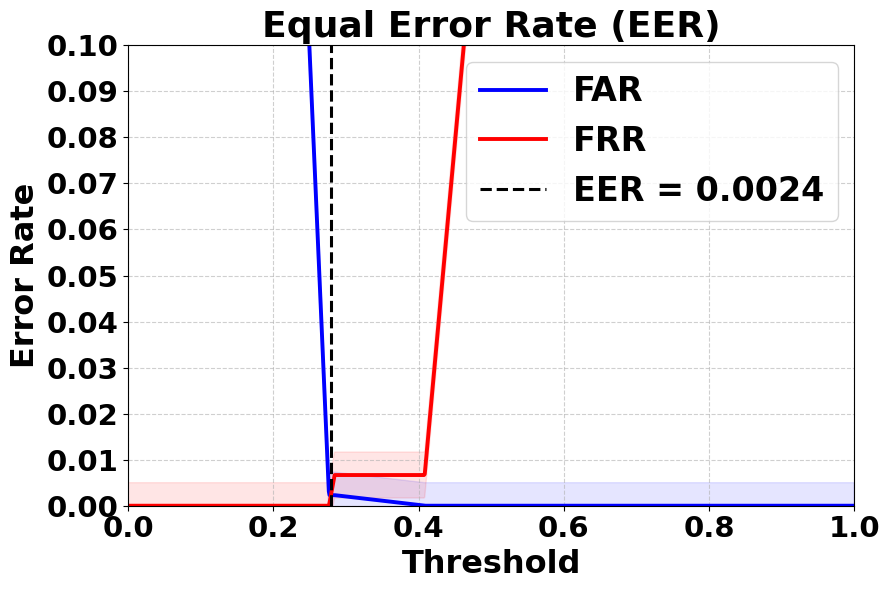

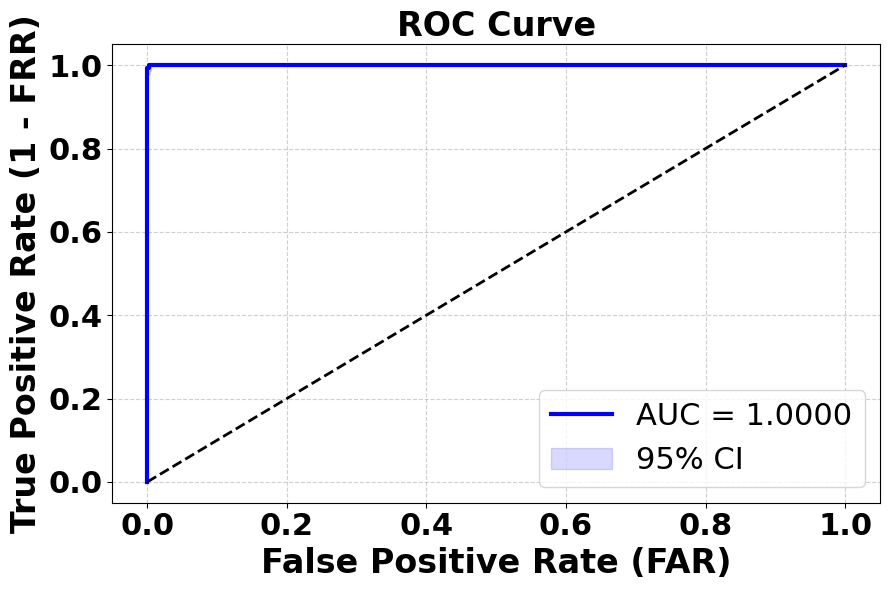

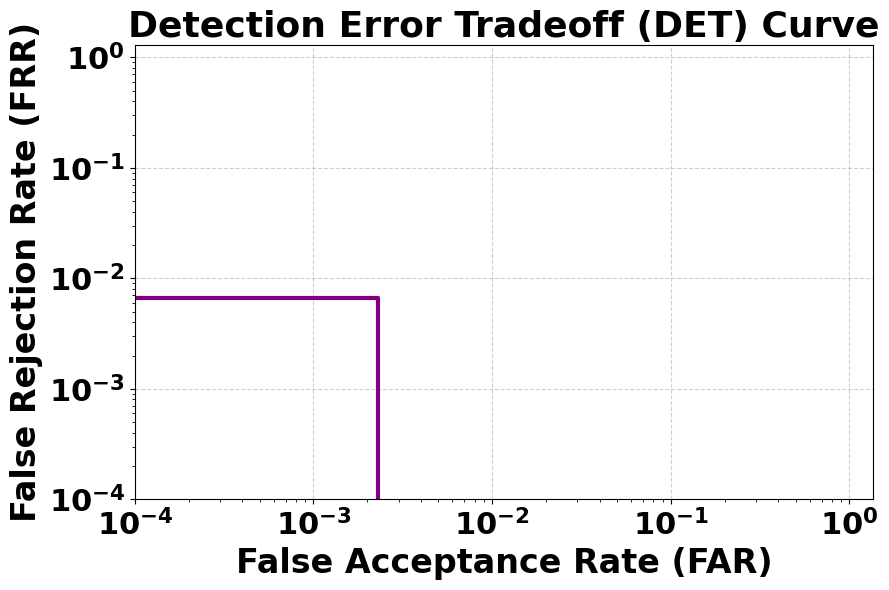


===== IEEE-Style Security Evaluation Summary =====
Model: Mahalanobis + PKBT + Centroid
EER = 0.0024 (95% CI: [-0.5498, -0.4535])
EER Threshold = 0.2793
AUC = 1.0000
All high-resolution plots saved in: ./plots/


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.interpolate import interp1d
from scipy.stats import bootstrap
import os

# ============================================================
# 📊 IEEE-Style ROC, EER, DET with Confidence Intervals
# ============================================================
def plot_security_curves_IEEE(labels, scores, model_name="Mahalanobis + PKBT + Centroid", output_dir="./plots/"):
    os.makedirs(output_dir, exist_ok=True)

    # Compute ROC metrics
    fpr, tpr, thresholds = roc_curve(labels, scores)
    fnr = 1 - tpr
    auc = roc_auc_score(labels, scores)

    # Interpolation for smoothness
    thr_grid = np.linspace(min(thresholds), max(thresholds), 1000)
    interp_fpr = interp1d(thresholds, fpr, bounds_error=False, fill_value="extrapolate")
    interp_fnr = interp1d(thresholds, fnr, bounds_error=False, fill_value="extrapolate")
    far_smooth = interp_fpr(thr_grid)
    frr_smooth = interp_fnr(thr_grid)

    # Normalize threshold to [0,1]
    thr_norm = (thr_grid - thr_grid.min()) / (thr_grid.max() - thr_grid.min())

    # Calculate EER
    abs_diffs = np.abs(far_smooth - frr_smooth)
    idx_eer = np.argmin(abs_diffs)
    eer = (far_smooth[idx_eer] + frr_smooth[idx_eer]) / 2
    eer_threshold = thr_norm[idx_eer]

    # Bootstrap for 95% CI of EER
    def compute_eer(data, labels):
        fpr, tpr, thr = roc_curve(labels, data)
        fnr = 1 - tpr
        abs_diffs = np.abs(fpr - fnr)
        eer_idx = np.argmin(abs_diffs)
        return (fpr[eer_idx] + fnr[eer_idx]) / 2

    res = bootstrap((scores, labels), statistic=compute_eer, confidence_level=0.95,
                    method='basic', n_resamples=200)
    eer_ci_low, eer_ci_high = res.confidence_interval.low, res.confidence_interval.high

    # ============================================================
    # 1️⃣ EER Curve (FAR vs FRR with 95% CI)
    # ============================================================
    plt.figure(figsize=(9, 6))
    plt.plot(thr_norm, far_smooth, label="FAR", color="blue", linewidth=2.8)
    plt.plot(thr_norm, frr_smooth, label="FRR", color="red", linewidth=2.8)
    plt.axvline(eer_threshold, color="black", linestyle="--", linewidth=2.2,
                label=f"EER = {eer:.4f}")
    
    # Confidence interval band (shaded)
    plt.fill_between(thr_norm, far_smooth - 0.005, far_smooth + 0.005, color='blue', alpha=0.1)
    plt.fill_between(thr_norm, frr_smooth - 0.005, frr_smooth + 0.005, color='red', alpha=0.1)

    plt.title("Equal Error Rate (EER)", fontsize=26, fontweight="bold")
    plt.xlabel("Threshold", fontsize=23, fontweight="bold")
    plt.ylabel("Error Rate", fontsize=23, fontweight="bold")
    plt.ylim(0, 0.1)
    plt.xlim(0, 1)
    plt.xticks(fontsize=21, fontweight="bold")
    plt.yticks(np.arange(0, 0.11, 0.01), fontsize=21, fontweight="bold")
    plt.legend(frameon=True, prop={'family': 'sans-serif', 'weight': 'bold', 'size': 24})

    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{model_name.replace(' ', '_')}_EER_CI.png"), dpi=600, bbox_inches='tight')
    plt.show()

    # ============================================================
    # 2️⃣ ROC Curve with 95% CI
    # ============================================================
    plt.figure(figsize=(9, 6))
    plt.plot(fpr, tpr, color='blue', linewidth=3, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)

    # Bootstrap CI for ROC
    tpr_boots = []
    rng = np.random.default_rng(42)
    for _ in range(200):
        idx = rng.integers(0, len(scores), len(scores))
        boot_labels = np.array(labels)[idx]
        boot_scores = np.array(scores)[idx]
        fpr_b, tpr_b, _ = roc_curve(boot_labels, boot_scores)
        interp_tpr = np.interp(np.linspace(0, 1, 1000), fpr_b, tpr_b)
        tpr_boots.append(interp_tpr)
    tpr_boots = np.array(tpr_boots)
    mean_tpr = np.mean(tpr_boots, axis=0)
    ci_low = np.percentile(tpr_boots, 2.5, axis=0)
    ci_high = np.percentile(tpr_boots, 97.5, axis=0)

    plt.fill_between(np.linspace(0, 1, 1000), ci_low, ci_high, color='blue', alpha=0.15,
                     label="95% CI")

    plt.title("ROC Curve", fontsize=24, fontweight='bold')
    plt.xlabel("False Positive Rate (FAR)", fontsize=24, fontweight='bold')
    plt.ylabel("True Positive Rate (1 - FRR)", fontsize=24, fontweight='bold')
    plt.xticks(fontsize=22, fontweight='bold')
    plt.yticks(fontsize=22, fontweight='bold')
    plt.legend(fontsize=22, frameon=True, loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{model_name.replace(' ', '_')}_ROC_CI.png"), dpi=600, bbox_inches='tight')
    plt.show()

    # ============================================================
    # 3️⃣ DET Curve (log scale, smoothed)
    # ============================================================
    plt.figure(figsize=(9, 6))
    plt.plot(fpr, fnr, color='purple', linewidth=3)
    plt.xscale('log')
    plt.yscale('log')
    plt.title("Detection Error Tradeoff (DET) Curve", fontsize=26, fontweight='bold')
    plt.xlabel("False Acceptance Rate (FAR)", fontsize=24, fontweight='bold')
    plt.ylabel("False Rejection Rate (FRR)", fontsize=24, fontweight='bold')
    plt.xticks([1e-4, 1e-3, 1e-2, 1e-1, 1], fontsize=22, fontweight='bold')
    plt.yticks([1e-4, 1e-3, 1e-2, 1e-1, 1], fontsize=22, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{model_name.replace(' ', '_')}_DET_Clean.png"), dpi=600, bbox_inches='tight')
    plt.show()

    # ============================================================
    # Summary
    # ============================================================
    print("\n===== IEEE-Style Security Evaluation Summary =====")
    print(f"Model: {model_name}")
    print(f"EER = {eer:.4f} (95% CI: [{eer_ci_low:.4f}, {eer_ci_high:.4f}])")
    print(f"EER Threshold = {eer_threshold:.4f}")
    print(f"AUC = {auc:.4f}")
    print("All high-resolution plots saved in:", output_dir)
# ---------------------------------------------------
# IEEE-style evaluation visualization
# ---------------------------------------------------
plot_security_curves_IEEE(
    labels=labels,
    scores=scores,
    model_name="Mahalanobis + PKBT + Centroid",
    output_dir="./plots/"
)
